In [226]:
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric, NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from scipy.io import arff
from scipy.spatial.distance import pdist, squareform
import random
import pandas as pd
import numpy as np


In [227]:
def load_data(path):
    data = arff.loadarff(path)

    return pd.DataFrame(data[0])

In [228]:
def process_data(raw_df, lvq = None, num_epochs : int = 10, lr : int = 0.001, proto_mult : int = 1, w = 0.2):
    scaler = MinMaxScaler()

    raw_X = raw_df.drop(columns=['defects'])

    scaled_X_data = scaler.fit_transform(raw_X.values)

    X = pd.DataFrame(scaled_X_data, index=raw_X.index, columns=raw_X.columns)

    raw_df['defects'] = raw_df['defects'].apply(lambda i: b'true' == i)

    y = raw_df['defects']

    if lvq is not None:
        X, y = lvq(X, y, num_epochs=num_epochs, lr=lr, proto_mult=proto_mult, w=w)

    return X, y, raw_df

In [229]:
def get_knn(k=None, **kwargs):
    return KNeighborsClassifier(n_neighbors=k, weights='uniform', metric='euclidean', **kwargs)

def get_knn_weighted(k=None, **kwargs):
    return KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean', **kwargs)

In [309]:
def lvq1(X : pd.DataFrame, y : pd.DataFrame,  num_epochs : int = 10, lr : int = 0.3, proto_mult : int = 10, **kwargs):
    num_dims = X.shape[1]
    unique_labels = list(set(y))
    num_labels = len(unique_labels)
    num_protos = num_labels * proto_mult

    random.seed(21)
    random_proto_indices = random.sample(range(len(X)), num_protos)

    protos = X.iloc[random_proto_indices]
    protos = protos.to_numpy(np.float64)

    proto_labels = y.iloc[random_proto_indices]
    proto_labels = proto_labels.to_numpy()

    X = X.drop(random_proto_indices).reset_index(drop=True)
    y = y.drop(random_proto_indices).reset_index(drop=True)

    neigh = NearestNeighbors(n_neighbors=1)

    print(protos)
    neigh.fit(protos)

    for epoch in range(0, num_epochs):
        for (x_index, x) in X.iterrows():
            [[nearest_proto_index]] = neigh.kneighbors([x], return_distance=False)
            proto = protos[nearest_proto_index]
            if proto_labels[nearest_proto_index] == y[x_index]:
                protos[nearest_proto_index] = proto + (x.tolist() - proto) * lr
            else:
                protos[nearest_proto_index] = proto - (x.tolist() - proto) * lr
    
    return protos, proto_labels

In [310]:
def lvq21(X : pd.DataFrame, y : pd.DataFrame,  num_epochs : int = 30, lr : int = 0.001, proto_mult : int = 3, w = 0.2):
    num_dims = X.shape[1]
    unique_labels = list(set(y))
    num_labels = len(unique_labels)
    num_protos = num_labels * proto_mult
    
    random.seed(21)
    random_proto_indices = random.sample(range(len(X)), num_protos)

    protos = X.iloc[random_proto_indices]
    protos = protos.to_numpy()

    proto_labels = y.iloc[random_proto_indices]
    proto_labels = proto_labels.to_numpy()

    X = X.drop(random_proto_indices).reset_index(drop=True)
    y = y.drop(random_proto_indices).reset_index(drop=True)

    neigh = NearestNeighbors(n_neighbors=2)
    neigh.fit(protos)

    s = (1-w)/(1+w)

    for epoch in range(0, num_epochs):
        for (x_index, x) in X.iterrows():
            [[dxpi, dxpj]], [[i, j]] = neigh.kneighbors([x], return_distance=True)
            pi = protos[i]
            pj = protos[j]
            if min(dxpi/dxpj, dxpj/dxpi) > s:
                if proto_labels[i] != proto_labels[j]:
                    if proto_labels[i] == y[x_index]:
                        protos[i] = pi + (x.tolist() - pi) * lr
                        protos[j] = pj - (x.tolist() - pj) * lr
                    else:
                        protos[i] = pi - (x.tolist() - pi) * lr
                        protos[j] = pj + (x.tolist() - pj) * lr
    
    return protos, proto_labels

In [311]:
def lvq3(X : pd.DataFrame, y : pd.DataFrame,  num_epochs : int = 30, lr : int = 0.001, proto_mult : int = 3, w = 0.2, e = 0.1):
    num_dims = X.shape[1]
    unique_labels = list(set(y))
    num_labels = len(unique_labels)
    num_protos = num_labels * proto_mult

    random.seed(21)
    random_proto_indices = random.sample(range(len(X)), num_protos)

    protos = X.iloc[random_proto_indices]
    protos = protos.to_numpy()
    # print(protos)
    
    # protos = np.empty((num_protos, num_dims), dtype=np.float64)
    proto_labels = y.iloc[random_proto_indices]
    proto_labels = proto_labels.to_numpy()

    X = X.drop(random_proto_indices)
    y = y.drop(random_proto_indices)

    neigh = NearestNeighbors(n_neighbors=2)
    
    neigh.fit(protos)

    s = (1-w)/(1+w)

    for epoch in range(0, num_epochs):
        for (x_index, x) in X.iterrows():
            [[dxpi, dxpj]], [[i, j]] = neigh.kneighbors([x], return_distance=True)
            pi = protos[i]
            pj = protos[j]
            # print(f"{pi=}\n {pj=}\n{dxpi=}\n{dxpj=}\n{i=}\n{j}")
            if dxpj != 0 or dxpi != 0 or min(dxpi/dxpj, dxpj/dxpi) > s:
                if proto_labels[i] != proto_labels[j]:
                    if proto_labels[i] == y[x_index]:
                        protos[i] = pi + (x.tolist() - pi) * lr
                        protos[j] = pj - (x.tolist() - pj) * lr
                    else:
                        protos[i] = pi - (x.tolist() - pi) * lr
                        protos[j] = pj + (x.tolist() - pj) * lr
                else:
                    protos[i] = pi + (x.tolist() - pi) * lr * e
                    protos[j] = pj + (x.tolist() - pj) * lr * e
            
    
    return protos, proto_labels

In [312]:
def grid_search(X, y, knn=None):

    param_grid = { 'n_neighbors': [1,3,5] }

    scoring = {
            'accuracy' : make_scorer(accuracy_score),
            'recall' : make_scorer(recall_score), 
            'f1_score' : make_scorer(f1_score)
            }

    knn_gscv = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='accuracy')

    knn_gscv.fit(X, y)

    return knn_gscv

In [313]:
def plot_search_results(grid, title):
    import matplotlib.pyplot as plt
    labels = [1,3,5]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the ars results = grid.cv_results_

    results = grid.cv_results_

    print(f"Accuracies {results['mean_test_accuracy']}")

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, results['mean_test_accuracy'], width)
    ax.set_ylabel('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # fig.show()
    fig.tight_layout()
    fig.savefig(title + '.png')

In [314]:
data = load_data('../data/cm1.arff')

In [315]:
X_pure, X_pure, raw2 = process_data(data.copy())
knn_gscv_kc1 = grid_search(X_pure, X_pure, get_knn())

In [316]:
## KC1
X1, y1, raw = process_data(data.copy(), lvq1, proto_mult=40, lr=0.1, num_epochs=7, w=0.2)
knn_gscv_kc1_lvq1 = grid_search(X1, y1, get_knn())
plot_search_results(knn_gscv_kc1, 'kc1-knn-lvq1')

In [ ]:
X21, y21, raw = process_data(data.copy(), lvq21, proto_mult=40, lr=0.1, num_epochs=7, w=0.2)
knn_gscv_kc1_lvq21 = grid_search(X21, y21, get_knn())
plot_search_results(knn_gscv_kc1, 'kc1-knn-lvq21')

In [ ]:
X3, y3, raw = process_data(data.copy(), lvq3, proto_mult=40, lr=0.1, num_epochs=7, w=0.2)
knn_gscv_kc1_lvq3 = grid_search(X3, y3, get_knn())
plot_search_results(knn_gscv_kc1, 'kc1-knn-lvq3')

No handles with labels found to put in legend.
Accuracies [0.8875 0.8625 0.8875]


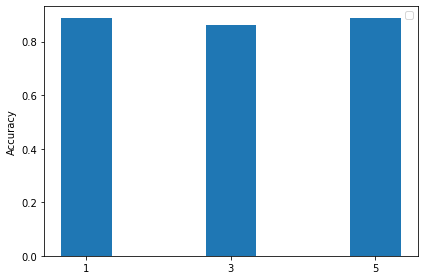

No handles with labels found to put in legend.
Accuracies [0.84549495 0.87955556 0.89161616]


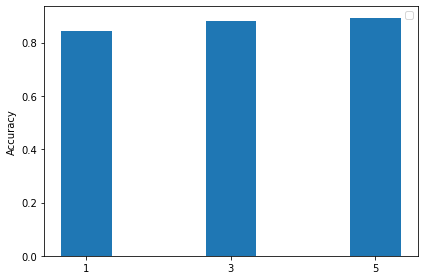

In [318]:
plot_search_results(knn_gscv_kc1, 'kc1-standard-no-preprocessing')